In [90]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utide import solve

In [92]:
from analysis_routines import *
from plotting_routines_xr import *
from harmonic_analysis import *
from wavelet_analysis import *
from processing_routines import datenum_to_epoch
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

# Harmoic analysis & Utide

In [93]:
df_ci = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
df_c = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fc.csv')
df_s = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_s.csv')

In [94]:
data = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')

In [517]:
G05_ci = pd.read_csv(data_dir / 'SHDR_fit' / 'aux' / 'G05_ci.csv', index_col = 'date', parse_dates=True)
delta05_ci = pd.read_csv(data_dir / 'SHDR_fit' / 'aux' / 'delta05_ci.csv', index_col='date', parse_dates=True)

### Completo

In [18]:
complete_ci = TidalComponentsFit.compute(df_ci, period=[None, None, 6])

In [19]:
complete_ci.clean()

In [20]:
complete_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,5.618951,39.174451,2.928870,0.917180,47.610279,17.941438
K1,23.934470,3.675320,18.264360,2.368754,1.086360,146.534635,26.281745
2Q1,28.006223,2.024010,10.056212,1.757837,1.086470,245.726421,35.412104
L2,12.191620,1.483654,10.344140,1.505008,0.917165,16.728448,34.916092
O1,25.819342,1.074583,5.341629,1.280832,1.086204,266.146244,48.612076


### Mareas internas en noviembre, MLD ~ 40 m

In [519]:
# trim time series
dn = 1 # get datapoints every 60 seconds, not every 5
date_1 = datetime(2018, 11, 24)
nov_ci = TidalComponentsFit.compute(df_ci, period=[None, date_1, dn])
#nov_c = TidalComponentsFit.compute(df_c, period=[None, date_1, dn])
#nov_s = TidalComponentsFit.compute(df_s, period=[None, date_1, dn])
nov_G05ci = coef_dataframe(G05_ci.x, period=[None, date_1, dn])
nov_delta05ci = coef_dataframe(delta05_ci.x, period=[None, date_1, dn])
nov_ci.clean()
#nov_c.clean()
#nov_s.clean()

In [520]:
nov_delta05ci

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,75.299497,18.250588,4.298004,1.971898,9.388968,26.313479
M3,8.280401,11.801153,53.247986,1.701504,0.457022,271.797210,15.454998
K1,23.934470,3.682839,4.204462,0.950522,0.908580,262.351228,54.660406
2MK5,4.930880,2.585568,7.428230,0.796432,0.572746,156.724528,41.124055
M4,6.210301,2.580820,41.484521,0.795701,0.242138,340.991481,17.381505
M6,4.140200,1.645032,2.315461,0.635269,0.818268,339.126927,73.661311
M8,3.105150,1.093386,5.125214,0.517914,0.448392,340.988483,49.657168
2SK5,4.797373,0.833508,2.397691,0.452195,0.572381,141.375094,72.476410
3MK7,3.529641,0.478196,1.597001,0.342511,0.531224,22.974347,88.962688


In [102]:
temp_43 = data.temp.sel(depth=43)
temp_53 = data.temp.sel(depth=53)
temp_63 = data.temp.sel(depth=63)
temp_78 = data.temp.sel(depth=63)
depth_48 = data.meassured_depth.sel(depth=48)

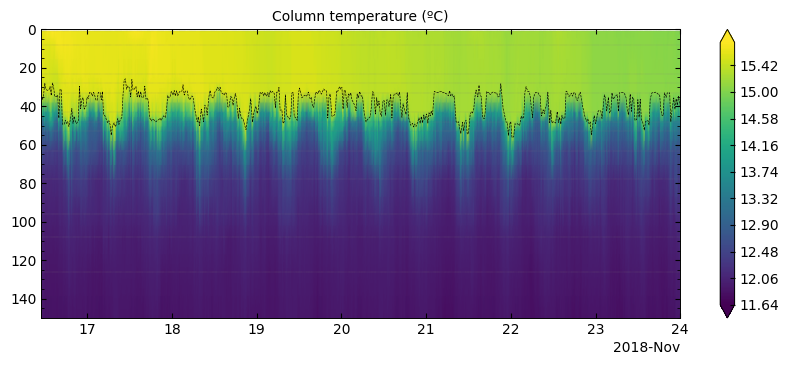

In [100]:
plot_column_temperature(data, df_ci, period=[None, date_1], ylims=[150, 0], save='column_end_november.jpg')

In [103]:
temp_43_ut_nov = coef_dataframe(temp_43, period=[None, date_1])
temp_53_ut_nov = coef_dataframe(temp_53, period=[None, date_1])
temp_63_ut_nov = coef_dataframe(temp_63, period=[None, date_1])
temp_78_ut_nov = coef_dataframe(temp_78, period=[None, date_1])
depth_48_ut_nov = coef_dataframe(depth_48, period=[None, date_1])

In [649]:
class column_coefs:
    def __init__(self, depths):
        self.depths = depths

    def compute(self, data, period=[None, None, 6], lat=43.789):
        slice_ = slice(*period)
        for depth in self.depths:
            temp = data.temp.sel(date=slice_, depth=depth)
            coef = coef_dataframe(temp, period=period, lat=lat)
            setattr(self, 'd' + str(depth), coef)
            
    def clean(self):
        for depth in self.depths:
            coef = getattr(self, 'd' + str(depth))
            coef = coef[coef['SNR'] > 2.0]
            coef = coef[coef['A'] > coef['A_ci']]
            coef = coef[coef['PE'] > 1]
            setattr(self, 'd' + str(depth), coef)
            
    def plot(self, component, mld_coef, delta05_coef, pos1, pos2, x_arrow):
        x = []
        ci = []
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

        mld_mean = mld_coef.attrs['mean']
        mld_ampl = mld_coef.loc[component]['A']
        delta_mean = delta05_coef.attrs['mean']
        delta_ampl = delta05_coef.loc[component]['A']
        for depth in self.depths:
            coef = getattr(self, 'd' + str(depth))
            value = coef.loc[component]['A']
            confidence = coef.loc[component]['A_ci']
            ci.append(confidence)
            x.append(value)
            
        fig, ax = plt.subplots()
        ax.scatter(x, self.depths)
        ax.errorbar(x, self.depths, xerr=ci, marker='o', linestyle='none', lw=0.8, capsize=3, c='k')
        ax.axhline(mld_mean, ls='--')
        ax.axhline(mld_mean + delta_mean, ls='--', c=colors[1])
        xlim = ax.get_xlim()
        ax.set_ylim(max(self.depths) + 2, min(self.depths) - 2)
        mld_mean_arr = np.full(2, mld_mean)
        plt.fill_between((xlim[0], xlim[1]), (mld_mean_arr-mld_ampl), (mld_mean_arr+mld_ampl), color=colors[0], alpha=0.35)
        plt.fill_between((xlim[0], xlim[1]), (mld_mean + delta_mean-delta_ampl), (mld_mean + delta_mean+delta_ampl), color=colors[1], alpha=0.35)

        ax.set_xlim(*xlim)
        ax.set_xlabel('Oscilation amplitude (ºC)')
        ax.set_ylabel('Depth')
        ax.set_title('Tidal component ' + component)
        ax.arrow(x = x_arrow, y = mld_mean - mld_ampl, dy=2*mld_ampl, dx=0, width=0.001, length_includes_head=True, head_width=0.02, head_length=2, color='k')
        ax.arrow(x = x_arrow, y = mld_mean + mld_ampl, dy=-2*mld_ampl, dx=0, width=0.001, length_includes_head=True, head_width=0.02, head_length=2, color='k')

        ax.arrow(x = x_arrow, y = mld_mean + delta_mean - delta_ampl, dy=2*delta_ampl, dx=0, width=0.001, length_includes_head=True, head_width=0.02, head_length=2, color='k')
        ax.arrow(x = x_arrow, y = mld_mean + delta_mean + delta_ampl, dy=-2*delta_ampl, dx=0, width=0.001, length_includes_head=True, head_width=0.02, head_length=2, color='k')
        #ax.annotate(text='', xy=(x_arrow,mld_mean - mld_ampl), xytext=(x_arrow,mld_mean + mld_ampl), arrowprops=dict(arrowstyle='<->'))
        ax.text(pos1[0], pos1[1], 'MLD oscilation amplitude', transform=ax.transAxes)
        ax.text(pos2[0], pos2[1], r'$\Delta_{0.05}$ oscilation amplitude', transform=ax.transAxes)

        plt.show()
        
            
    

In [650]:
mld_coef = coef_dataframe(df_ci['D1'], period=[None, date_1])
delta05_filtered = lowpass_filter(delta05_ci.x[None:date_1:1], delta05_ci[None:date_1:1].index, 1/5, 1/512)
nov_delta05ci = coef_dataframe(delta05_filtered, period=[None, date_1, 1])


In [651]:
a = column_coefs([28, 33, 43, 48, 53, 63, 78, 96])
a.compute(data, period=[None, date_1])

In [652]:
a.clean()

In [653]:
nov_delta05ci

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,75.298807,18.269977,4.299358,1.971472,9.379382,26.299516
M3,8.280401,11.808229,53.406239,1.702558,0.456627,271.864489,15.432073
K1,23.934470,3.682504,4.204892,0.950783,0.908782,262.442633,54.657515
M4,6.210301,2.591023,41.525853,0.797527,0.242573,340.884229,17.373011
2MK5,4.930880,2.573851,7.393473,0.794879,0.572972,156.809769,41.220355
M6,4.140200,1.651842,2.323209,0.636786,0.818853,339.011465,73.538874
M8,3.105150,1.092930,5.126236,0.517971,0.448397,340.777508,49.651915
2SK5,4.797373,0.826376,2.376863,0.450400,0.572601,141.260105,72.794111
3MK7,3.529641,0.474438,1.584450,0.341271,0.531393,22.729273,89.315222


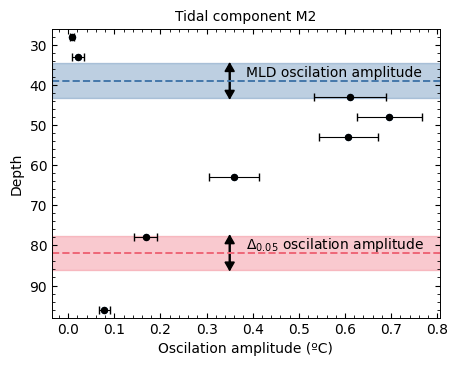

In [654]:
a.plot('M2', mld_coef, nov_delta05ci, pos1=[0.5, 0.835], pos2=[0.5, 0.24],x_arrow=0.35)

In [ ]:
a.d48['g']

In [454]:
a.d53['g']

name
M2    7.402371
M4    2.997258
Name: g, dtype: float64

In [63]:
temp_43_ut_nov

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,95.780062,233.283522,0.611445,0.078464,7.826306,7.360073
M3,8.280401,1.502485,18.353837,0.076582,0.035036,138.729217,26.198457
M6,4.140200,1.095290,18.987192,0.065386,0.029411,209.469611,25.738362
M8,3.105150,0.585580,11.188014,0.047809,0.028015,43.845032,33.575748
2MK5,4.930880,0.337159,2.960520,0.036277,0.041325,293.538813,65.392299
K1,23.934470,0.329860,4.297723,0.035883,0.033925,324.536765,54.206040
2SK5,4.797373,0.176804,1.549147,0.026270,0.041369,222.792127,90.205469
3MK7,3.529641,0.113016,0.746809,0.021003,0.047637,281.206025,129.757743
M4,6.210301,0.079745,0.534453,0.017643,0.047301,13.460422,153.072859


In [64]:
temp_53_ut_nov

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,94.223825,346.077280,0.607363,0.063991,7.402371,6.042817
M4,6.210301,4.215996,20.157646,0.128475,0.056086,2.997258,24.914763
K1,23.934470,0.800976,21.873734,0.055999,0.023468,327.730445,24.032357
M6,4.140200,0.358749,5.737371,0.037477,0.030666,290.244287,46.974121
M8,3.105150,0.161398,5.566420,0.025137,0.020883,359.743729,47.662159
M3,8.280401,0.084853,0.947208,0.018226,0.036706,183.480557,114.901077
3MK7,3.529641,0.073228,1.003275,0.016932,0.033132,74.023204,111.964646
2MK5,4.930880,0.070497,0.601282,0.016613,0.041992,165.868854,144.465293
2SK5,4.797373,0.010478,0.089433,0.006405,0.041977,207.060366,374.862894


In [104]:
temp_63_ut_nov

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,90.031693,172.946408,0.359200,0.053535,4.520252,8.548301
M4,6.210301,7.282499,97.222889,0.102159,0.020307,358.484432,11.344502
K1,23.934470,0.620643,8.441891,0.029824,0.020118,323.111046,38.672762
M8,3.105150,0.479382,18.421465,0.026211,0.011969,12.657170,26.196522
M6,4.140200,0.439789,6.775062,0.025105,0.018904,348.099552,43.044315
2MK5,4.930880,0.357217,21.741252,0.022626,0.009511,122.886290,24.112249
2SK5,4.797373,0.352864,21.444163,0.022488,0.009518,138.299558,24.242396
3MK7,3.529641,0.302102,4.509848,0.020807,0.019204,73.062985,52.810763
M3,8.280401,0.133812,1.365556,0.013848,0.023227,235.334539,96.244388


In [52]:
nov_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,91.212216,128.360171,4.358130,0.753948,4.559901,9.922482
M4,6.210301,4.156208,25.527518,0.930298,0.360889,10.268133,22.144801
M3,8.280401,2.334067,16.475463,0.697157,0.336641,132.402670,27.677507
K1,23.934470,1.166679,8.296263,0.492889,0.335401,331.125555,39.030855


In [12]:
nov_G05ci

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,81.157757,16.402115,0.007531,0.003645,189.835948,27.785098
M3,8.280401,7.599659,17.055332,0.002305,0.001094,113.440600,27.247126
K1,23.934470,2.335848,1.621543,0.001278,0.001967,84.940794,88.177040
M6,4.140200,2.239285,3.205354,0.001251,0.001370,159.193548,62.635529
M4,6.210301,2.081996,9.939774,0.001206,0.000750,159.915692,35.495587
2MK5,4.930880,1.772736,4.802860,0.001113,0.000995,344.457197,51.106825
M8,3.105150,1.392402,5.558023,0.000986,0.000820,153.118548,47.696739
2SK5,4.797373,0.812554,2.209961,0.000754,0.000994,297.491567,75.633531
3MK7,3.529641,0.607762,1.497129,0.000652,0.001044,219.857826,91.821921


In [17]:
nov_ci.a2

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
K1,23.934470,40.367505,5.841401,0.010447,0.008472,237.168550,46.425518
M3,8.280401,16.820349,35.239596,0.006744,0.002227,229.844554,18.931012
3MK7,3.529641,10.064092,24.000023,0.005216,0.002087,50.619725,22.915948
M4,6.210301,6.277320,11.200822,0.004120,0.002413,84.144633,33.684455
2SK5,4.797373,3.592271,6.790368,0.003117,0.002344,101.098347,43.214495
M8,3.105150,2.394439,12.768704,0.002544,0.001396,62.632760,31.402822
2MK5,4.930880,2.156874,4.068907,0.002415,0.002346,127.220244,55.714405


### Mareas internas principios de diciembre
Mayor amplitud que en noviembre > columna menos estratificada

In [281]:
date_2 = datetime(2018, 11, 30)
date_3 = datetime(2018, 12, 9)
dn = 6 # get datapoints every 60 seconds, not every 5
dec_ci = TidalComponentsFit.compute(df_ci, period=[date_2, date_3, 1])

dec_ci.clean()

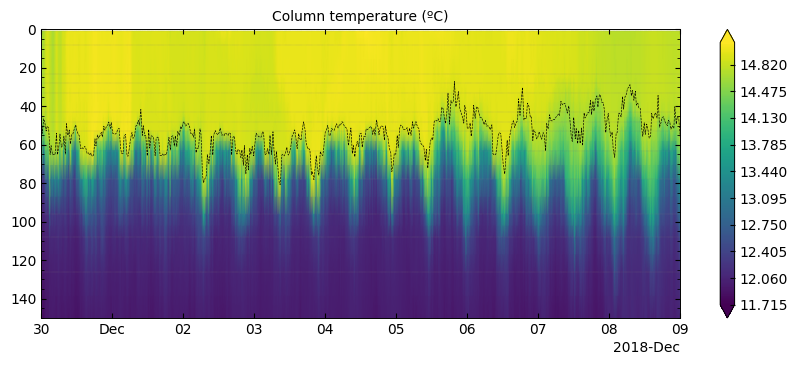

In [282]:
plot_column_temperature(data, df_ci, period=[date_2, date_3], ylims=[150, 0])

In [567]:
b = column_coefs([28, 33, 43, 48, 53, 63, 78, 96, 108])
b.compute(data, period=[date_2, date_3])
b.clean()

In [573]:
delta05_filtered = lowpass_filter(delta05_ci.x[date_2:date_3:1], delta05_ci[date_2:date_3:1].index, 1/5, 1/1024)
dec_delta05ci = coef_dataframe(delta05_filtered, period=[date_2, date_3, 1])

In [577]:
dec_delta05ci

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,68.215002,122.686978,6.107566,1.080749,37.893978,10.125624
K1,23.934470,19.665291,7.990540,3.279279,2.273769,276.987020,39.553581
2SK5,4.797373,4.806868,20.886006,1.621285,0.695325,52.388376,24.566276
M3,8.280401,3.243872,13.603475,1.331865,0.707768,121.498694,30.475034
M4,6.210301,2.137208,7.636286,1.081064,0.766773,193.065100,40.521021
2MK5,4.930880,0.717170,3.115107,0.626238,0.695439,163.659753,63.589872
3MK7,3.529641,0.651809,1.893506,0.597019,0.850376,101.372487,81.588255
M6,4.140200,0.359079,2.386533,0.443122,0.562206,10.636976,72.613683
M8,3.105150,0.203702,1.401736,0.333753,0.552521,85.063349,94.862176


In [578]:
dec_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,92.572526,265.127233,6.290885,0.757252,8.089549,6.862304
M4,6.210301,1.249753,6.431931,0.730942,0.564896,43.068735,44.270426
2SK5,4.797373,1.042750,35.583096,0.667668,0.219379,248.496964,18.812072
M3,8.280401,1.020903,6.725656,0.660637,0.499289,305.414705,43.330506


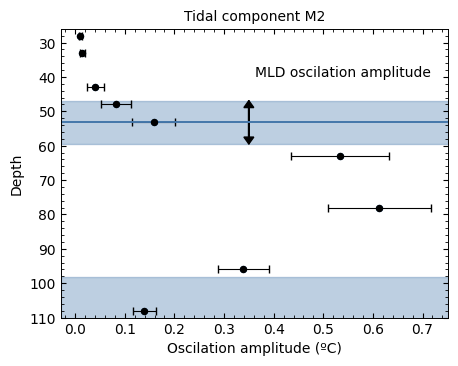

In [575]:
b.plot('M2', dec_ci.D1, dec_delta05ci, pos=[0.5, 0.835], x_arrow=0.35)

In [ ]:
b.

In [23]:
dec_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,92.535645,266.030496,6.281629,0.754853,8.013315,6.850779
M4,6.210301,1.261436,6.551205,0.733416,0.561624,42.949152,43.865001
2SK5,4.797373,1.044287,40.018415,0.667310,0.206754,248.650199,17.738680
M3,8.280401,1.040178,7.047954,0.665996,0.491695,303.666911,42.333197


In [24]:
dec_ci.b2

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,65.313225,9.250388,0.009088,0.005856,171.219382,36.740344
M4,6.210301,9.250515,33.270349,0.003420,0.001162,260.135840,19.528351
K1,23.934470,7.325612,5.379877,0.003044,0.002572,216.070450,48.483932
M6,4.140200,6.337007,7.109072,0.002831,0.002081,130.732111,42.125824
2MK5,4.930880,4.160065,11.136096,0.002294,0.001347,196.101088,33.632324
M8,3.105150,3.676344,7.224148,0.002156,0.001572,236.134549,41.783426
2SK5,4.797373,2.368833,6.341266,0.001731,0.001347,298.193647,44.570148


## January

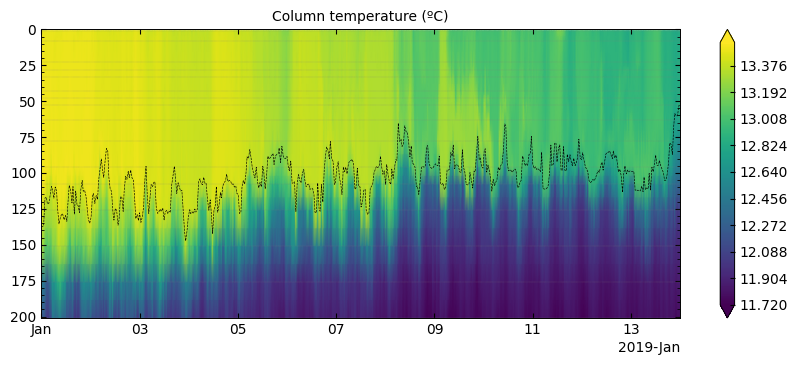

In [327]:
date_6 = datetime(2019, 1, 1)
date_7 = datetime(2019, 1, 14)
plot_column_temperature(data, df_ci, period=[date_6, date_7])

In [351]:
c= column_coefs([96, 108, 126, 151, 176])
c.compute(data, period=[date_6, date_7])
c.clean()

In [344]:
mld_january = coef_dataframe(df_ci['D1'], period=[date_6, date_7])

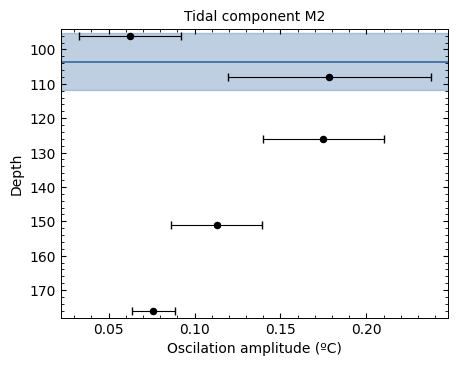

In [347]:
c.plot('M2', mld_january)

In [25]:
date_4 = datetime(2018, 12, 30, 12)
date_5 = datetime(2019, 1, 14)
dn = 6 # get datapoints every 60 seconds, not every 5
wint_ci = TidalComponentsFit.compute(df_ci, period=[date_4, date_5, dn])
wint_c = TidalComponentsFit.compute(df_c, period=[date_4, date_5, dn])
wint_s = TidalComponentsFit.compute(df_s, period=[date_4, date_5, dn])

In [26]:
wint_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,83.995428,208.252798,8.572150,1.164261,61.241914,7.775781
O1,25.819342,7.849280,7.551337,2.620456,1.869050,227.981525,40.870562
M4,6.210301,2.943525,11.876867,1.604707,0.912643,166.174191,32.599037
K1,23.934470,2.871330,2.759836,1.584906,1.869898,123.936220,67.544022
M8,3.105150,0.605832,11.034244,0.728011,0.429559,222.905126,33.807046
M3,8.280401,0.557106,3.848181,0.698121,0.697524,329.273208,57.225674
2SK5,4.797373,0.432927,9.052105,0.615417,0.400913,355.429821,37.346444
3MK7,3.529641,0.338813,4.536154,0.544430,0.501019,286.936870,52.692034
2MK5,4.930880,0.221673,4.627160,0.440371,0.401252,82.604125,52.147524


In [28]:
wint_ci.b2

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,55.288163,25.736781,0.007923,0.003061,271.252009,22.103982
O1,25.819342,15.554548,15.175736,0.004202,0.002114,161.650295,28.804845
M4,6.210301,12.122555,10.749022,0.003710,0.002218,287.812072,34.239844
K1,23.934470,4.161412,4.070519,0.002174,0.002112,163.401020,55.761139
2MK5,4.930880,3.765107,5.215543,0.002068,0.001774,53.834241,49.155919
M3,8.280401,3.569135,8.913255,0.002013,0.001322,321.217097,37.608709
M8,3.105150,2.128982,7.294621,0.001555,0.001128,293.777665,41.579476
3MK7,3.529641,1.894655,10.727403,0.001467,0.000878,314.558470,34.286726
M6,4.140200,0.906096,1.768867,0.001014,0.001495,154.655956,84.454285


### FFT

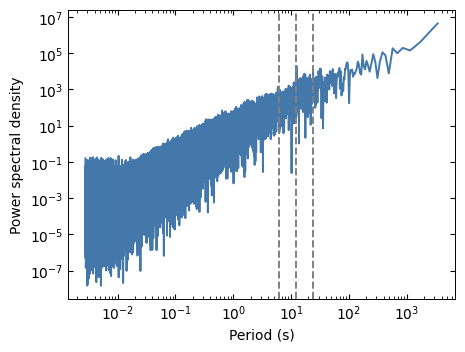

In [77]:
D1 = df_ci[datetime(2018, 11, 16):datetime(2018, 12, 27):120*6]['D1'].to_numpy()
D1 = df_ci['D1'].to_numpy()
sampling_rate = period_to_freq(5, 's')
lowcut = period_to_freq(13, 'h')
highcut = period_to_freq(11, 'h')
#D1_filtered = bandstop_filter(D1, sampling_rate, lowcut, highcut, order=5)
freqs, ampl, power, psd = spectrum(D1, 5/60/60, 1)
plot_spectrum(freqs, psd, 's', x='period', vlines=[12.405, 6.21, 23.93])

In [15]:
date_4 = datetime(2018, 11, 30)
date_5 = datetime(2018, 12, 9)
dn = 6 # get datapoints every 30 seconds, not every 5
complete_ci = TidalComponentsFit.compute(df_ci, period=[None, None, dn])
complete_c = TidalComponentsFit.compute(df_c, period=[None, None, dn])
complete_s = TidalComponentsFit.compute(df_s, period=[None, None, dn])

complete_ci.clean()
complete_c.clean()
complete_s.clean()

In [16]:
complete_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,5.618951,39.174451,2.928870,0.917180,47.610279,17.941438
K1,23.934470,3.675320,18.264360,2.368754,1.086360,146.534635,26.281745
2Q1,28.006223,2.024010,10.056212,1.757837,1.086470,245.726421,35.412104
L2,12.191620,1.483654,10.344140,1.505008,0.917165,16.728448,34.916092
O1,25.819342,1.074583,5.341629,1.280832,1.086204,266.146244,48.612076


In [127]:
D1_ = df_ci['D1'][:date_1]
D1_lowpass = lowpass_filter(D1_, 1/5, 1/512)

<class 'datetime.timedelta'>
<class 'numpy.ndarray'> None


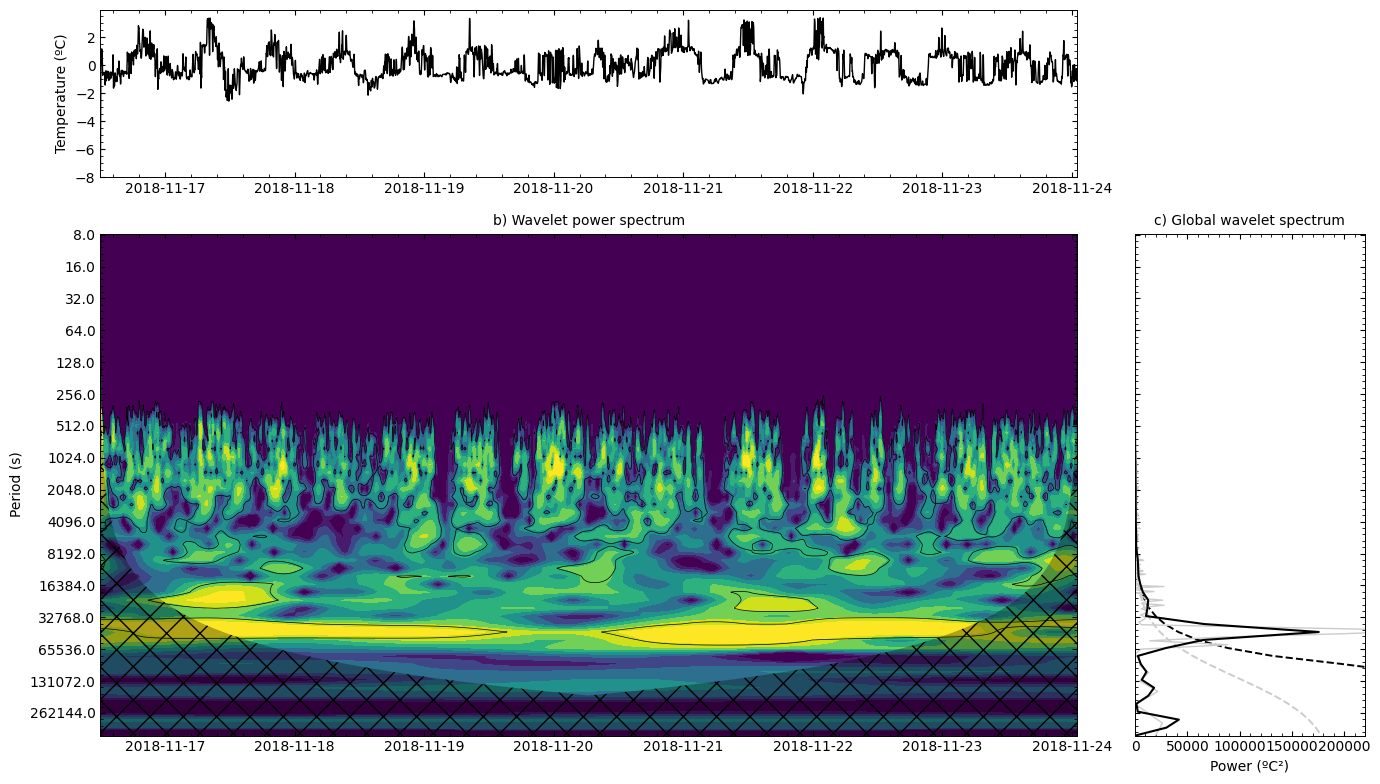

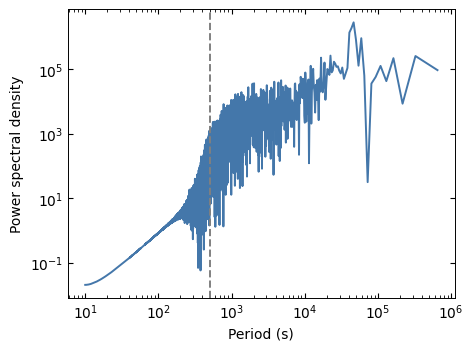

In [131]:
wavelet_power_spectrum(D1_lowpass, df_ci.index, period=[None, date_1, 1])
freqs, ampl, power, psd = spectrum(D1_lowpass, 5, 1)
plot_spectrum(freqs, psd, 's', x='period', vlines=[512])

In [72]:
date_0 = datetime(2018, 11, 23)
temp_7_period = data.temp[:, 8].sel(date=slice(datetime(2018, 11, 20), date_0, 1))


51841


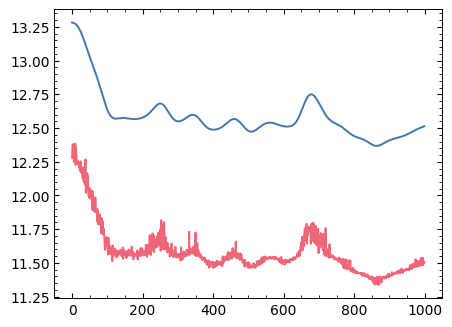

In [87]:
temp_7_highcut = lowpass_filter(temp_7_period, 1/5, 1/256, order=5)
plt.plot(temp_7_highcut[:1000])
plt.plot(temp_7_period[:1000]-1)
print(len(temp_7_highcut))


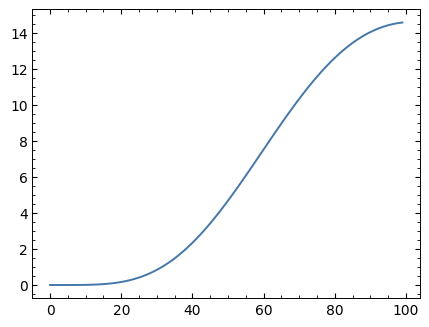

In [20]:
plt.plot(temp_7_highcut[0:100])